In [1]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries
from calcwf import chirp2total

We have implicitly assumed so far that the reference frequency of the waveforms was the Keplerian frequency. This is not the case for TEOBResumS, where the reference frequency is defined as the average of the peri- and apastron frequencies. If we are therefore able to convert from the Keplerian frequency ($\omega_\textrm{kep}$) to this TEOBResumS average frequency ($\omega_\textrm{avg}$) we should be able to increase eccentricity while keeping the initial Keplerian frequency constant. This should then give a decreased signal length as we would expect.

Equation 3 in https://arxiv.org/pdf/2207.14346.pdf gives the instantaneous orbital frequency as follows:

$$
\omega (t) = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\cos{E(t)}\right]^2}
$$

The frequency is highest (lowest) at the periastron (apastron). Therefore $\omega_\textrm{peri}$ ($\omega_\textrm{ap}$) corresponds to when $\cos{E(t)} = +1$ ($-1$). Therefore the average frequency used in TEOBResumS is given by:

$$
\omega_\textrm{avg} = \frac{1}{2} \left( \omega_\textrm{peri} + \omega_\textrm{ap} \right) = \frac{1}{2} \left( \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\right]^2} + \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[1+e\right]^2} \right)
$$

$$
\omega_\textrm{avg} = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{2} \left( \frac{ \left(1+e\right)^2 + \left(1-e\right)^2}{\left(1+e\right)^2 \left(1-e\right)^2} \right)
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right) \sqrt{1-e^2}}{\left(1+e\right)^2 \left(1-e\right)^2}
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}~~~~~\textrm{or equivalently}~~~~~f_\textrm{avg} = f_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}
$$

Can now write functions converting between $f_\textrm{kep}$ and $f_\textrm{avg}$.

In [2]:
def f_kep2avg(f_kep, e):

    numerator = (1+e**2)
    denominator = (1-e**2)**(3/2)

    return f_kep*(numerator/denominator)

def f_avg2kep(f_avg, e):

    numerator = (1-e**2)**(3/2)
    denominator = (1+e**2)

    return f_avg*(numerator/denominator)

In [3]:
# Converts modes to use into language TEOBResumS understands
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

In [4]:
# Generates TEOBResumS waveform with given parameters
def gen_teob_wf(f_kep, e, M, q, sample_rate, phase):

    f_avg = f_kep2avg(f_kep, e)

    # Define parameters
    k = modes_to_k([[2,2]])
    pars = {
            'M'                  : M,
            'q'                  : q,
            'Lambda1'            : 0.,
            'Lambda2'            : 0.,     
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 0,            # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 0,
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p, teob_c

Now input (and plot) two indentical sets of parameters except one with higher eccentricity

In [5]:
hp, hc = gen_teob_wf(10, 0.1, 30, 2, 4096, 0)
sp, sc = gen_teob_wf(10, 0.2, 30, 2, 4096, 0)

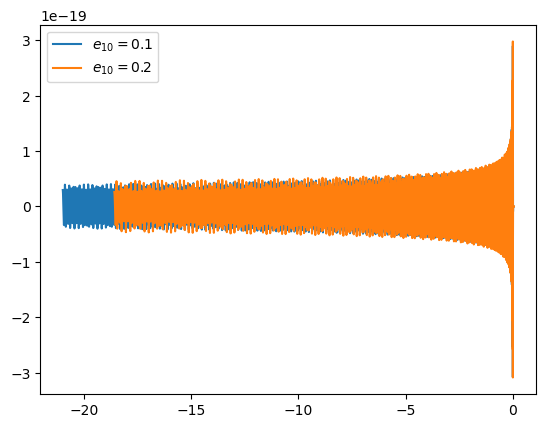

In [6]:
plt.plot(hp.sample_times, hp, label='$e_{10} = 0.1$')
plt.plot(sp.sample_times, sp, label='$e_{10} = 0.2$')
plt.legend()

Now higher eccentricity does indeed give lower signal length as we expect due to the faster orbital evolution!

Finally, we should plot waveforms with shifted $f_\textrm{kep}$ using orbital evolution equations to give a shift in true anomaly by 2pi. If our problem has been fixed, the equations should be accurate, and the envelopes of the waveforms should line up.

In [7]:
from calcwf import shifted_f, shifted_e

In [8]:
hp, hc = gen_teob_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 0)
s_f = shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_e = shifted_e(s_f, 10, 0.1)
sp, sc = gen_teob_wf(s_f, s_e, chirp2total(24, 2), 2, 4096, 0)

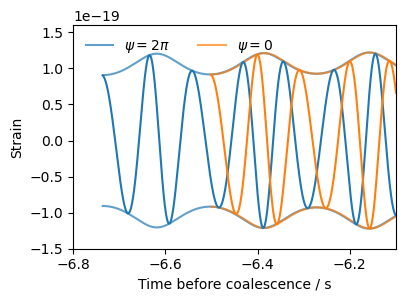

In [9]:
plt.figure(figsize=(0.65*6.4,0.65*4.8))
plt.plot(sp.sample_times, np.sqrt(sp**2 + sc**2), label='$\psi=2\pi$', alpha=0.7)
plt.plot(hp.sample_times, np.sqrt(hp**2 + hc**2), label='$\psi=0$', alpha=0.7)
plt.plot(sp.sample_times, -np.sqrt(sp**2 + sc**2), c='C0', alpha=0.7)
plt.plot(hp.sample_times, -np.sqrt(hp**2 + hc**2), c='C1', alpha=0.7)
plt.plot(sp.sample_times, sp, c='C0')
plt.plot(hp.sample_times, hp, c='C1')
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-6.8, -6.1)
plt.ylim(-1.5e-19, 1.6e-19)
plt.tight_layout()
plt.savefig('Figures/2piTA.pdf')

Success!